# 

# Data Transformations and Summaries

In this chapter, we introduce the **dplyr** package \[@R-dplyr\], which
is part of the **tidyverse** group of packages, to expand our tools in
exploring and transforming our data. We learn how to do some basic
manipulations of data (e.g., adding or removing columns, filtering data,
arranging by one or multiple columns) as well as how to summarize data
(e.g., grouping by values, calculating summary statistics). We also
practice combining these operations using the pipe operator `%>%` from
the **tidyverse**. We use the same sample of the National Health and
Nutrition Examination Survey \[@nhanes\] as in **?@sec-exploratory**.

In [ ]:
library(HDSinRdata)
library(tidyverse)

data(NHANESsample)

## Tibbles and Data Frames

Take a look at the class of `NHANESsample`. As we might expect, the data
is stored as a data frame.

In [ ]:
class(NHANESsample)

[1] "data.frame"

However, **tidyverse** packages also work with another data structure
called a **tibble**. A **tibble** has all the properties of data frames
that we have learned so far, but they are a more modern version of a
data frame. To convert our data to this data structure, we use the
`as_tibble()` function. In practice, there are only very slight
differences between the two data structures, and you generally do not
need to convert data frames to tibbles. In the following code chunks, we
convert our data from a data frame to a tibble and print the head of the
data before converting it back to a data frame and repeating. You can
see the two structures have a slightly different print statement but are
otherwise very similar.

In [ ]:
nhanes_df <- as_tibble(NHANESsample)
print(head(nhanes_df))

# A tibble: 6 × 21
     ID   AGE SEX    RACE             EDUCATION INCOME SMOKE  YEAR  LEAD BMI_CAT
  <dbl> <dbl> <fct>  <fct>            <fct>      <dbl> <fct> <dbl> <dbl> <fct>  
1     2    77 Male   Non-Hispanic Wh… MoreThan…   5    Neve…  1999   5   BMI<=25
2     5    49 Male   Non-Hispanic Wh… MoreThan…   5    Quit…  1999   1.6 25<BMI…
3    12    37 Male   Non-Hispanic Wh… MoreThan…   4.93 Neve…  1999   2.4 BMI>=30
4    13    70 Male   Mexican American LessThan…   1.07 Quit…  1999   1.6 25<BMI…
5    14    81 Male   Non-Hispanic Wh… LessThan…   2.67 Stil…  1999   5.5 25<BMI…
6    15    38 Female Non-Hispanic Wh… MoreThan…   4.52 Stil…  1999   1.5 25<BMI…
# ℹ 11 more variables: LEAD_QUANTILE <fct>, HYP <dbl>, ALC <chr>, DBP1 <dbl>,
#   DBP2 <dbl>, DBP3 <dbl>, DBP4 <dbl>, SBP1 <dbl>, SBP2 <dbl>, SBP3 <dbl>,
#   SBP4 <dbl>

In [ ]:
nhanes_df <- as.data.frame(nhanes_df)
print(head(nhanes_df))

  ID AGE    SEX               RACE  EDUCATION INCOME      SMOKE YEAR LEAD
1  2  77   Male Non-Hispanic White MoreThanHS   5.00 NeverSmoke 1999  5.0
2  5  49   Male Non-Hispanic White MoreThanHS   5.00  QuitSmoke 1999  1.6
3 12  37   Male Non-Hispanic White MoreThanHS   4.93 NeverSmoke 1999  2.4
4 13  70   Male   Mexican American LessThanHS   1.07  QuitSmoke 1999  1.6
5 14  81   Male Non-Hispanic White LessThanHS   2.67 StillSmoke 1999  5.5
6 15  38 Female Non-Hispanic White MoreThanHS   4.52 StillSmoke 1999  1.5
    BMI_CAT LEAD_QUANTILE HYP ALC DBP1 DBP2 DBP3 DBP4 SBP1 SBP2 SBP3 SBP4
1   BMI<=25            Q4   0 Yes   58   56   56   NA  106   98   98   NA
2 25<BMI<30            Q3   1 Yes   82   84   82   NA  122  122  122   NA
3   BMI>=30            Q4   1 Yes  108   98  100   NA  182  172  176   NA
4 25<BMI<30            Q3   1 Yes   78   62   70   NA  140  130  130   NA
5 25<BMI<30            Q4   1 Yes   56   NA   58   64  142   NA  134  138
6 25<BMI<30            Q3   0 Yes   68

We mention tibbles here since some functions in the **tidyverse**
convert data frames to tibbles in their output. In particular, when we
later summarize over groups we can expect a tibble to be returned. It is
useful to be aware that our data may change data structure with such
functions and to know that we can always convert back if needed.

## Subsetting Data   

In earlier chapters, we have seen how to select and filter data using
row and column indices as well as using the `subset()` function. The
**dplyr** package has its own functions that are useful for subsetting
data. The `select()` function allows us to select a subset of columns:
this function takes in the data frame (or tibble) and the names or
indices of the columns we want to select. For example, if we only wanted
to select the variables for race and blood lead level, we could specify
these two columns. To display the result of this selection, we use the
pipe operator `%>%` from the **magittr** package of the **tidyverse**.
Similar to the pipe operator `|>` in base R, the pipe operator `%>%`
takes the result on the left-hand side and passes it as the first
argument to the function on the right-hand side. The following output
shows that there are only two columns in the filtered data.

In [ ]:
select(nhanes_df, c(RACE, LEAD)) %>% head()

                RACE LEAD
1 Non-Hispanic White  5.0
2 Non-Hispanic White  1.6
3 Non-Hispanic White  2.4
4   Mexican American  1.6
5 Non-Hispanic White  5.5
6 Non-Hispanic White  1.5

The `select()` function can also be used to *remove* columns by adding a
negative sign in front of the vector of column names in its arguments.
For example, we keep all columns except `ID` and `LEAD_QUANTILE`. Note
that in this case we have saved the selected data back to our data frame
`nhanes_df`. Additionally, this time we used a pipe operator to pipe the
data to the select function itself.

In [ ]:
nhanes_df <- nhanes_df %>% select(-c(ID, LEAD_QUANTILE))
names(nhanes_df)

 [1] "AGE"       "SEX"       "RACE"      "EDUCATION" "INCOME"    "SMOKE"    
 [7] "YEAR"      "LEAD"      "BMI_CAT"   "HYP"       "ALC"       "DBP1"     
[13] "DBP2"      "DBP3"      "DBP4"      "SBP1"      "SBP2"      "SBP3"     
[19] "SBP4"     

While `select()` allows us to choose a subset of columns, the `filter()`
function allows us to choose a subset of rows. The `filter()` function
takes a data frame as the first argument and a vector of Booleans as the
second argument. This vector of Booleans can be generated using
conditional statements as we used in **?@sec-exploratory**. We choose to
filter the data to only observations after 2008.

In [ ]:
nhanes_df_recent <- nhanes_df %>% filter(YEAR >= 2008)

We can combine conditions by using multiple `filter()` calls, by
creating a more complicated conditional statement using the `&` (and),
`|` (or), and `%in%` (in) operators, or by separating the conditions
with commas within filter. In the following code, we demonstrate these
three ways to filter the data to males between 2008 and 2012. Note that
the `between()` function allows us to capture the logic
`YEAR >= 2008 & YEAR <= 2012`.

In [ ]:
# Example 1: multiple filter calls
nhanes_df_males1 <- nhanes_df %>%
  filter(YEAR <= 2012) %>%
  filter(YEAR >= 2008) %>%
  filter(SEX == "Male")

# Example 2: combine with & operator
nhanes_df_males2 <- nhanes_df %>%
  filter((YEAR <= 2012) & (YEAR >= 2008) & (SEX == "Male"))

# Example 3: combine into one filter call with commas
nhanes_df_males3 <- nhanes_df %>%
  filter(between(YEAR, 2008, 2012), SEX == "Male")

The use of parentheses in the previous code is especially important in
order to capture our desired logic. In all these examples, we broke our
code up into multiple lines, which makes it easier to read. A good rule
of thumb is to not go past 80 characters in a line, and R Studio
conveniently has a vertical gray line at this limit. To create a new
line, you can hit enter either after an operator (e.g., `%>%`, `+`, `|`)
or within a set of unfinished brackets or parentheses. Either of these
breaks lets R know that your code is not finished yet.

Lastly, we can subset the data using the `slice()` function to select a
slice of rows by their index. The function takes in the dataset and a
vector of indices. In the following example, we find the first and last
rows of the data.

In [ ]:
slice(nhanes_df, c(1, nrow(nhanes_df)))

  AGE  SEX               RACE  EDUCATION INCOME      SMOKE YEAR LEAD BMI_CAT
1  77 Male Non-Hispanic White MoreThanHS   5.00 NeverSmoke 1999  5.0 BMI<=25
2  38 Male Non-Hispanic White MoreThanHS   1.56 StillSmoke 2017  0.9 BMI>=30
  HYP ALC DBP1 DBP2 DBP3 DBP4 SBP1 SBP2 SBP3 SBP4
1   0 Yes   58   56   56   NA  106   98   98   NA
2   1 Yes   98   92   98   NA  150  146  148   NA

A few other useful slice functions are `slice_sample()`, `slice_max()`,
and `slice_min()`. The first takes in an argument `n` which specifies
the number of *random* rows to sample from the data. For example, we
could randomly sample 100 rows from our data. The latter two allow us to
specify a column through the argument `order_by` and return the `n` rows
with either the highest or lowest values in that column. For example, we
can find the three male observations from 2007 with the highest and
lowest blood lead levels and select a subset of columns to display.

In [ ]:
# three male observations with highest blood lead level in 2007
nhanes_df %>%
  filter(YEAR == 2007, SEX == "Male") %>%
  select(c(RACE, EDUCATION, SMOKE, LEAD, SBP1, DBP1)) %>%
  slice_max(order_by = LEAD, n = 3)

                RACE  EDUCATION      SMOKE LEAD SBP1 DBP1
1 Non-Hispanic Black LessThanHS NeverSmoke 33.1  106   66
2     Other Hispanic LessThanHS StillSmoke 26.8  106   72
3     Other Hispanic LessThanHS StillSmoke 25.7  112   60

                RACE  EDUCATION      SMOKE      LEAD SBP1 DBP1
1 Non-Hispanic White LessThanHS NeverSmoke 0.1767767  114   80
2     Other Hispanic LessThanHS  QuitSmoke 0.2800000  122   62
3   Mexican American MoreThanHS  QuitSmoke 0.3200000  112   66

### Practice Question

Filter the data to only those with an education level of more than HS
who report alcohol use. Then, select only the diastolic blood pressure
variables and display the fourth and tenth rows. Your result should
match the result in
<a href="#fig-filtering-and-selecting" class="quarto-xref">Figure 1</a>.

<figure id="fig-filtering-and-selecting">
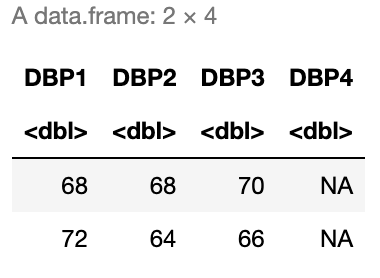
<figcaption>Figure 1: Filtering and Selecting Data.</figcaption>
</figure>

In [ ]:
# Insert your solution here:

## Updating Rows and Columns   

The next few functions we look at allow us to update the rows and
columns in our data. For example, the `rename()` function allows us to
change the names of columns. In the following code, we change the name
of `INCOME` to `PIR` since this variable is the poverty income ratio and
also update the name of `SMOKE` to be `SMOKE_STATUS`. When specifying
these names, the new name is on the left of the `=` and the old name is
on the right.

In [ ]:
nhanes_df <- nhanes_df %>% rename(PIR = INCOME, SMOKE_STATUS = SMOKE)
names(nhanes_df)

 [1] "AGE"          "SEX"          "RACE"         "EDUCATION"    "PIR"         
 [6] "SMOKE_STATUS" "YEAR"         "LEAD"         "BMI_CAT"      "HYP"         
[11] "ALC"          "DBP1"         "DBP2"         "DBP3"         "DBP4"        
[16] "SBP1"         "SBP2"         "SBP3"         "SBP4"        

In the last chapter, we created a new variable called `EVER_SMOKE` based
on the smoking status variable using the `ifelse()` function. Recall
that this function allows us to specify a condition, and then two
alternative values based on whether we meet or do not meet this
condition. We see that there are about 15,000 subjects in our data who
never smoked.

In [ ]:
ifelse(nhanes_df$SMOKE_STATUS == "NeverSmoke", "No", "Yes") %>% 
  table()

.
   No   Yes 
15087 16178 

Another useful function from the **tidyverse** is the `case_when()`
function, which is an extension of the `ifelse()` function but allows to
specify more than two cases. We demonstrate this function to show how we
could relabel the levels of the `SMOKE_STATUS` column. For each
condition, we use the right side of the `~` to specify the value to be
assigned when that condition is TRUE.

In [ ]:
case_when(nhanes_df$SMOKE_STATUS == "NeverSmoke" ~ "Never Smoked",
          nhanes_df$SMOKE_STATUS == "QuitSmoke" ~ "Quit Smoking",
          nhanes_df$SMOKE_STATUS == 
            "StillSmoke" ~ "Current Smoker") %>% 
  table()

.
Current Smoker   Never Smoked   Quit Smoking 
          7317          15087           8861 

In the previous example, we did not store the columns we created. To do
so, we could use the `$` operator or the `cbind()` function. The
**tidyverse** also includes an alternative function to add columns
called `mutate()`. This function takes in a data frame and a set of
columns with associated names to add to the data or update. In the
subsequent example, we create the column `EVER_SMOKE` and update the
column `SMOKE_STATUS`. Within the `mutate()` function, we do not have to
use the `$` operator to reference the column `SMOKE_STATUS`. Instead, we
can specify just the column name, and the function interprets it as that
column.

In [ ]:
nhanes_df <- nhanes_df %>% 
  mutate(EVER_SMOKE = ifelse(SMOKE_STATUS == "NeverSmoke", 
                             "No", "Yes"), 
         SMOKE_STATUS = 
           case_when(SMOKE_STATUS == "NeverSmoke" ~ "Never Smoked",
                     SMOKE_STATUS == "QuitSmoke" ~ "Quit Smoking",
                     SMOKE_STATUS == "StillSmoke" ~ "Current Smoker")) 

The last function we demonstrate in this section is the `arrange()`
function, which takes in a data frame and a vector of columns used to
sort the data (data is sorted by the first column with ties sorted by
the second column, etc.). By default, the `arrange()` function sorts the
data in increasing order, but we can use the `desc()` function to
instead sort in descending order. For example, the following code
filters the data to male smokers before sorting by decreasing systolic
and diastolic blood pressure in descending order. That is, the value of
`DBP1` is used to sort rows that have the same systolic blood pressure
values.

In [ ]:
nhanes_df %>% 
  select(c(YEAR, SEX, SMOKE_STATUS, SBP1, DBP1, LEAD)) %>%
  filter(SEX == "Male", SMOKE_STATUS == "Current Smoker") %>%
  arrange(desc(SBP1), desc(DBP1)) %>%
  head(8)

  YEAR  SEX   SMOKE_STATUS SBP1 DBP1 LEAD
1 2011 Male Current Smoker  230  120 5.84
2 2015 Male Current Smoker  230   98 1.56
3 2009 Male Current Smoker  220   80 4.84
4 2001 Male Current Smoker  218  118 3.70
5 2017 Male Current Smoker  212  122 2.20
6 2003 Male Current Smoker  212   54 4.00
7 2011 Male Current Smoker  210   92 5.37
8 2007 Male Current Smoker  210   80 2.18

If instead we had only sorted by `SBP1`, then the rows with the same
value for systolic blood pressure would appear in their original order.
You can see the difference in the following output.

In [ ]:
nhanes_df %>% 
  select(c(YEAR, SEX, SMOKE_STATUS, SBP1, DBP1, LEAD)) %>%
  filter(SEX == "Male", SMOKE_STATUS == "Current Smoker") %>%
  arrange(desc(SBP1)) %>%
  head(8)

  YEAR  SEX   SMOKE_STATUS SBP1 DBP1 LEAD
1 2011 Male Current Smoker  230  120 5.84
2 2015 Male Current Smoker  230   98 1.56
3 2009 Male Current Smoker  220   80 4.84
4 2001 Male Current Smoker  218  118 3.70
5 2003 Male Current Smoker  212   54 4.00
6 2017 Male Current Smoker  212  122 2.20
7 2007 Male Current Smoker  210   80 2.18
8 2011 Male Current Smoker  210   92 5.37

### Practice Question

Create a new column called `DBP_CHANGE` that is equal to the difference
between a patient’s first and fourth diastolic blood pressure readings.
Then, sort the data frame by this new column in increasing order and
print the first four rows. The first four `DBP_CHANGE` values in the
head of the resulting data frame should be $-66$, $-64$, $-64$, and
$-62$.

In [ ]:
# Insert your solution here:                    

## Summarizing and Grouping  

If we want to understand how many observations there are for each given
race category, we could use the `table()` function as we described in
earlier chapters. Another similar function is the `count()` function.
This function takes in a data frame and one or more columns and counts
the number of rows for each combination of unique values in these
columns. If no columns are specified, it counts the total number of rows
in the data frame. In the following code, we find the total number of
rows (31,265) and the number of observations by race and year. We can
see that the number in each group fluctuates quite a bit!

In [ ]:
count(nhanes_df)

      n
1 31265

                 RACE YEAR    n
1    Mexican American 1999  713
2    Mexican American 2001  674
3    Mexican American 2003  627
4    Mexican American 2005  634
5    Mexican American 2007  639
6    Mexican American 2009  672
7    Mexican American 2011  322
8    Mexican American 2013  234
9    Mexican American 2015  287
10   Mexican American 2017  475
11     Other Hispanic 1999  181
12     Other Hispanic 2001  129
13     Other Hispanic 2003   80
14     Other Hispanic 2005   96
15     Other Hispanic 2007  395
16     Other Hispanic 2009  367
17     Other Hispanic 2011  337
18     Other Hispanic 2013  167
19     Other Hispanic 2015  214
20     Other Hispanic 2017  313
21 Non-Hispanic White 1999 1401
22 Non-Hispanic White 2001 1882
23 Non-Hispanic White 2003 1785
24 Non-Hispanic White 2005 1818
25 Non-Hispanic White 2007 1940
26 Non-Hispanic White 2009 2169
27 Non-Hispanic White 2011 1463
28 Non-Hispanic White 2013  917
29 Non-Hispanic White 2015  685
30 Non-Hispanic White 2017 1413
31 Non-H

Finding the counts like we did previously is a form of a summary
statistic for our data. The `summarize()` function in the **tidyverse**
is used to compute summary statistics of the data and allows us to
compute multiple statistics: this function takes in a data frame and one
or more summary functions based on the given column names. In the
subsequent example, we find the total number of observations as well as
the mean and median systolic blood pressure for Non-Hispanic Blacks.
Note that the `n()` function is the function within `summarize()` that
finds the number of observations. In the `mean()` and `median()`
functions we set `na.rm=TRUE` to remove NAs before computing these
values (otherwise, we could get NA as our output).

In [ ]:
nhanes_df %>%
  filter(RACE == "Non-Hispanic Black") %>%
  summarize(TOT = n(), MEAN_SBP = mean(SBP1, na.rm=TRUE), 
            MEAN_DBP = mean(DBP1, na.rm=TRUE))

   TOT MEAN_SBP MEAN_DBP
1 6041 128.7584 72.59694

If we wanted to repeat this for the other race groups, we would have to
change the arguments to the `filter()` function each time. To avoid
having to repeat our code and/or do this multiple times, we can use the
`group_by()` function, which takes a data frame and one or more columns
with which to group the data. In the following code, we group using the
`RACE` variable. When we look at printed output, it looks almost the
same as it did before except that we can see that its class is now a
grouped data frame, which is printed at the top. In fact, a grouped data
frame (or grouped tibble) acts like a set of data frames: one for each
group. If we use the `slice()` function with index 1, it returns the
first row for each group.

In [ ]:
nhanes_df %>% 
  group_by(RACE) %>%
  slice(1)

# A tibble: 5 × 20
# Groups:   RACE [5]
    AGE SEX   RACE  EDUCATION   PIR SMOKE_STATUS  YEAR  LEAD BMI_CAT   HYP ALC  
  <dbl> <fct> <fct> <fct>     <dbl> <chr>        <dbl> <dbl> <fct>   <dbl> <chr>
1    70 Male  Mexi… LessThan…  1.07 Quit Smoking  1999   1.6 25<BMI…     1 Yes  
2    61 Fema… Othe… MoreThan…  3.33 Current Smo…  1999   2.2 BMI<=25     0 Yes  
3    77 Male  Non-… MoreThan…  5    Never Smoked  1999   5   BMI<=25     0 Yes  
4    38 Fema… Non-… HS         0.92 Current Smo…  1999   1.8 25<BMI…     0 Yes  
5    63 Fema… Othe… MoreThan…  5    Never Smoked  1999   1.2 BMI<=25     1 Yes  
# ℹ 9 more variables: DBP1 <dbl>, DBP2 <dbl>, DBP3 <dbl>, DBP4 <dbl>,
#   SBP1 <dbl>, SBP2 <dbl>, SBP3 <dbl>, SBP4 <dbl>, EVER_SMOKE <chr>

Grouping data is very helpful in combination with the `summarize()`
function. Like with the `slice()` function, `summarize()` calculates the
summary values for each group. We can now find the total number of
observations as well as the mean systolic and diastolic blood pressure
values for each racial group. Note that the returned summarized data is
in a tibble.

In [ ]:
nhanes_df %>% 
  group_by(RACE) %>%
  summarize(TOT = n(), MEAN_SBP = mean(SBP1, na.rm=TRUE), 
            MEAN_DBP = mean(DBP1, na.rm=TRUE))

# A tibble: 5 × 4
  RACE                 TOT MEAN_SBP MEAN_DBP
  <fct>              <int>    <dbl>    <dbl>
1 Mexican American    5277     124.     70.4
2 Other Hispanic      2279     123.     70.1
3 Non-Hispanic White 15473     125.     70.4
4 Non-Hispanic Black  6041     129.     72.6
5 Other Race          2195     122.     72.6

After summarizing, the data is no longer grouped by race. If we ever
want to remove the group structure from our data, we can use the
`ungroup()` function, which restores the data to a single data frame.
After ungrouping by race, we can see that we get a single observation
returned by the `slice()` function.

In [ ]:
nhanes_df %>% 
  select(SEX, RACE, SBP1, DBP1) %>%
  group_by(RACE) %>%
  ungroup() %>%
  arrange(desc(SBP1)) %>%
  slice(1)

# A tibble: 1 × 4
  SEX    RACE                SBP1  DBP1
  <fct>  <fct>              <dbl> <dbl>
1 Female Non-Hispanic White   270   124

### Practice Question

Create a data frame summarizing the percent of patients with
hypertension by smoking status. The result should look like
<a href="#fig-grouping-and-summarizing" class="quarto-xref">Figure 2</a>.

<figure id="fig-grouping-and-summarizing">
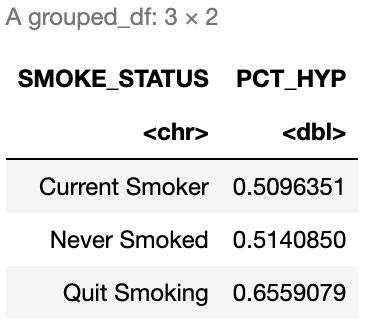
<figcaption>Figure 2: Grouping and Summarizing Data.</figcaption>
</figure>

In [ ]:
# Insert your solution here:

## Exercises

The following exercises use the `covidcases` dataset from the
**HDSinRdata** package. Before completing the exercises, be sure to read
the documentation for this data (`?covidcases`).

In [ ]:
data(covidcases)

1.  Suppose we are interested in the distribution of weekly cases by
    state. First, create a new column in `covidcases` called `region`
    specifying whether each state is in the Northeast, Midwest, South,
    or West (you can either do this by hand using [this
    list](https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States)
    of which states are in which region, or you can use `state.region`
    from the **datasets** package in R). Then, create a data frame
    summarizing the average and standard deviation of the weekly cases
    for the Northeast.

2.  Now, create a data frame with the average and standard deviation
    summarized for each region rather than for just one selected region
    as in Question 1. Sort this data frame from highest to lowest
    average weekly cases. What other information would you need in order
    to more accurately compare these regions in terms of their average
    cases?

3.  Find the ten counties in the Midwest with the lowest weekly deaths
    in week 15 of this data ignoring ties (use `slice_min()` to find the
    argument needed for this). What do you notice about the minimum
    values? See the data documentation for why we observe these values.

4.  Filter the data to include weeks 9 and 20 (around the start of the
    pandemic), get the total cases per county during that time frame,
    and then find the county in each state that had the highest number
    of total cases.